<a href="https://colab.research.google.com/github/BrassicaNapus/Class-Activation-Map/blob/main/CAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# gpu / cpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
# 데이터 전처리
transform = transforms.Compose(
    [transforms.Resize(128),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform
)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


In [5]:
# pretrained model
# ResNet18
model = torchvision.models.resnet18(pretrained=True)
print(model)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [6]:
num_ftrs = model.fc.in_features # fc의 입력 노드 수 512개
model.fc = nn.Linear(num_ftrs, 10) # cifar10 class 10개 (1000 -> 10)
model = model.to(device)

In [7]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
# 모델 학습
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    model.parameters(), lr=1e-5,
    weight_decay=1e-2 # 과적합 방지
)

In [9]:
loss_ = []
n = len(trainloader)

epochs = 20

for epoch in range(epochs + 1):
    
    running_loss = 0.0

    for data in trainloader:
    
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    cost = running_loss / n
    loss_.append(cost)

    print(epoch, ' loss: ', cost)

0  loss:  0.7929587911843033
1  loss:  0.28080420486648067
2  loss:  0.18005553299032362
3  loss:  0.1169635340395143
4  loss:  0.07475352849539779
5  loss:  0.04634411033609753
6  loss:  0.028756153366059217
7  loss:  0.020783436621891815
8  loss:  0.016083371659081018
9  loss:  0.013573838883767958
10  loss:  0.011565693199028358
11  loss:  0.012215641207884058
12  loss:  0.013099525960402258
13  loss:  0.010437819446809828
14  loss:  0.010584536995164111
15  loss:  0.011809753810303867
16  loss:  0.01144983651339198
17  loss:  0.010793261728999788
18  loss:  0.007943896430052097
19  loss:  0.010696362396996931
20  loss:  0.011367082338431216


In [10]:
PATH = './cifar10_resnet18.pth'
torch.save(model.state_dict(), PATH)

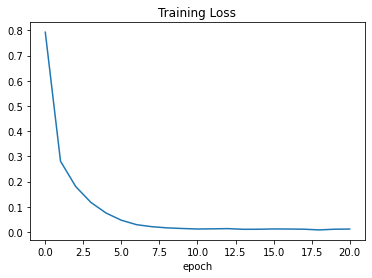

In [11]:
plt.plot(loss_)
plt.title("Training Loss")
plt.xlabel("epoch")
plt.show()

In [12]:
correct = 0
total = 0
with torch.no_grad():
    # model.eval()
    for data in trainloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('정확도: ', (100 * correct / total), '%')

정확도:  99.734 %


In [13]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
# Visualize feature maps
activation = {}
def get_activation(name): # 모델내에서 필터나 featrue map 등을 끄집어낼 때 쓰는 함수
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [15]:
def cam(model, trainset, img_sample, img_size):
    model.eval()
    with torch.no_grad(): # requires_grad 비활성화

        model.layer4[1].bn2.register_forward_hook(get_activation('final')) # feature extraction의 마지막 feature map 구하기
        data, label = trainset[img_sample] # 이미지 한 장과 라벨 불러오기
        data.unsqueeze_(0) # 4차원 3차원 [피쳐수 ,너비, 높이] -> [1,피쳐수 ,너비, 높이]
        output = model(data.to(device))
        _, prediction = torch.max(output, 1)
        act = activation['final'].squeeze() # 4차원 [1,피쳐수 ,너비, 높이] -> 3차원 [피쳐수 ,너비, 높이]
        w = model.fc.weight # classifer의 가중치 불러오기
        
        for idx in range(act.size(0)): # CAM 연산
            if idx == 0:
                tmp = act[idx] * w[prediction.item()][idx] 
            else:
                tmp += act[idx] * w[prediction.item()][idx]

        # 모든 이미지 팍셀값을 0~255로 스케일하기 
        normalized_cam = tmp.cpu().numpy()
        normalized_cam = (normalized_cam - np.min(normalized_cam)) / (np.max(normalized_cam) - np.min(normalized_cam))
        original_img = np.uint8((data[0][0] / 2 + 0.5) * 255)

        # 원본 이미지 사이즈로 리사이즈
        cam_img = cv2.resize(np.uint8(normalized_cam * 255), dsize=(img_size, img_size)) 
        
    return cam_img, original_img

In [16]:
def plot_cam(model, trainset, img_size, start):
    end = start + 20
    fig, axs = plt.subplots(2, (end - start + 1) // 2, figsize=(20, 5))
    fig.subplots_adjust(hspace=.01, wspace=.01)
    axs = axs.ravel()

    for i in range(start, end):
        cam_img, original_img = cam(model, trainset, i, img_size)

        axs[i - start].imshow(original_img, cmap='gray')
        axs[i - start].imshow(cam_img, cmap='jet', alpha=.5)
        axs[i - start].axis('off')

    plt.show()
    fig.savefig('cam.png')

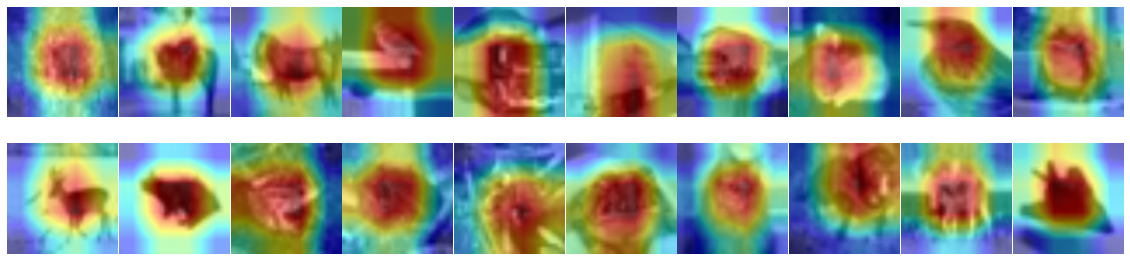

In [17]:
plot_cam(model, trainset, 128, 10)